In [26]:
import numpy as np
import pandas as pd

data = pd.DataFrame({'Age': [25, 37, 45, 30],
                     'Income': [75, 200, 100, 175],
                     'Married': ['No', 'No', 'Yes', 'Yes'],
                     'Loan Default': ['Yes', 'No', 'Yes', 'No']})

data

,Age,Income,Married,Loan Default
0,25,75,No,Yes
1,37,200,No,No
2,45,100,Yes,Yes
3,30,175,Yes,No


In [26]:
def decision_tree_if_1(data):
    if data['Age'] <= 37:
        if data['Income'] <= 100:
            return 'Yes'
        else:
            return 'No'
    else:
        if data['Income'] <= 175:
            return 'Yes'
        else:
            return 'No'
    
def decision_tree_if_2(data):
    if data['Married'] == 'Yes':
        if data['Income'] <= 150:
            return 'Yes'
        else:
            return 'No'
    else:
        if data['Income'] <= 100:
            return 'Yes'
        else:
            return 'No'

In [27]:
data['Decision tree 1'] = data.apply(decision_tree_if_1, axis=1)
data['Decision tree 2'] = data.apply(decision_tree_if_2, axis=1)
data

,Age,Income,Married,Loan Default,Decision tree 1,Decision tree 2
0,25,75,No,Yes,Yes,Yes
1,37,200,No,No,No,No
2,45,100,Yes,Yes,Yes,Yes
3,30,175,Yes,No,No,No


In [28]:
test_df = pd.DataFrame({'Age': [33, 61, 26, 44],
                        'Income': [150, 100, 150, 150],
                        'Married': ['Yes', 'Yes', 'Yes', 'No']})
test_df['Decision tree 1'] = test_df.apply(decision_tree_if_1, axis=1)
test_df['Decision tree 2'] = test_df.apply(decision_tree_if_2, axis=1)

test_df

,Age,Income,Married,Decision tree 1,Decision tree 2
0,33,150,Yes,No,Yes
1,61,100,Yes,Yes,Yes
2,26,150,Yes,No,Yes
3,44,150,No,Yes,No


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

data = pd.DataFrame(X, columns=iris.feature_names[2:])
data['target'] = y
data['target'] = data['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
data

,petal length (cm),petal width (cm),target
0,1.4,0.2,setosa
1,1.4,0.2,setosa
2,1.3,0.2,setosa
3,1.5,0.2,setosa
4,1.4,0.2,setosa
...,...,...,...
145,5.2,2.3,virginica
146,5.0,1.9,virginica
147,5.2,2.0,virginica
148,5.4,2.3,virginica


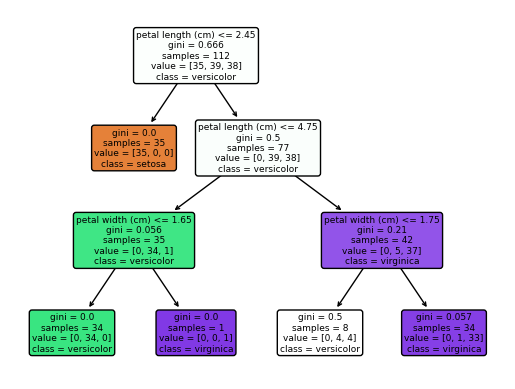

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

plot_tree(tree_clf, filled=True, rounded=True, class_names=iris.target_names, feature_names=iris.feature_names[2:])
plt.show()

In [30]:
X_test_df = pd.DataFrame(X_test, columns=iris.feature_names[2:])
X_test_df['actual'] = list(map(lambda x: iris.target_names[x], y_test))
X_test_df['predicted'] = list(map(lambda x: iris.target_names[x], tree_clf.predict(X_test)))
X_test_df.head(10)

,petal length (cm),petal width (cm),actual,predicted
0,4.7,1.2,versicolor,versicolor
1,1.7,0.3,setosa,setosa
2,6.9,2.3,virginica,virginica
3,4.5,1.5,versicolor,versicolor
4,4.8,1.4,versicolor,versicolor
5,1.5,0.4,setosa,setosa
6,3.6,1.3,versicolor,versicolor
7,5.1,2.3,virginica,virginica
8,4.5,1.5,versicolor,versicolor
9,3.9,1.2,versicolor,versicolor


In [ ]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [ ]:
from collections import Counter
class DecisionTree():
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if(depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value = leaf_value)
        
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_thresh, best_feature = self._best_split(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        ig = parent_entropy - child_entropy
        return ig
    
    def _split(self, X_column, threshold):
        left_idxs = np.argwhere(X_column <= threshold).flatten()
        right_idxs = np.argwhere(X_column > threshold).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / np.sum(hist)
        return -np.sum([p * np.log(p) for p in ps if p > 0])
        
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)